# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [43]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# --- parameters you might want to tune ---
MIN_MATCHES      = 25     # how many good matches are needed to accept a detection
RATIO_TEST       = 0.75   # Lowe ratio-test threshold
MAX_COPIES_PER_BOOK = 5   # stop after N matches per title to keep things fast
DRAW_SCALE       = 0.4    # scale overlays when showing large images


In [45]:
def load_ref_images(ref_dir):
    """
    Reads every file in `ref_dir`, extracts SIFT keypoints/descriptors and
    stores the original image plus its 4-corner rectangle (in ref space).
    """
    sift   = cv2.SIFT_create(nfeatures=10000)
    refs  = {}
    for path in sorted(Path(ref_dir).glob('*')):
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        kp, des = sift.detectAndCompute(img, None)
        h, w = img.shape[:2]
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        refs[path.stem] = dict(img=img, kp=kp, des=des, corners=corners)
    return refs, sift

def match_once(ref, scene_des, bf, ratio=RATIO_TEST):
    """
    Runs KNN match (k=2) between reference descriptors and scene descriptors,
    returns the list of good matches that pass Lowe ratio test.
    """
    matches = bf.knnMatch(ref['des'], scene_des, k=2)
    good = [m for m,n in matches if m.distance < ratio*n.distance]
    return sorted(good, key=lambda m: m.distance)

def compute_homography(ref_kp, scene_kp, good_matches):
    """
    With >=4 good matches, estimate H with RANSAC and return (H, mask).
    """
    if len(good_matches) < 4:
        return None, None
    src_pts = np.float32([ ref_kp[m.queryIdx].pt  for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H, mask

def mask_polygon(img, poly):
    """
    Draws a filled polygon on a mask to ignore an already-found copy.
    """
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, poly.astype(np.int32), 255)
    return cv2.bitwise_and(img, img, mask=cv2.bitwise_not(mask))

def deskew(img_gray):
    # 1. Canny → Hough per trovare le mensole (lunghe linee orizzontali)
    edges  = cv2.Canny(img_gray, 50, 150, apertureSize=3)
    lines  = cv2.HoughLines(edges, 1, np.pi/180, 200)
    if lines is None:               # scena senza mensole nette? fallback → gradiente
        return img_gray, 0
    # media degli angoli (ρ, θ); vogliamo l’offset rispetto a 0°
    angles = [(theta - np.pi/2) for rho,theta in lines[:,0]]
    angle  = np.rad2deg(np.median(angles))       # robusto ai fuori scala
    # 2. ruota mantenendo dimensioni
    (h,w)  = img_gray.shape[:2]
    M      = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    img_r  = cv2.warpAffine(img_gray, M, (w,h), flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_REPLICATE)
    return img_r, angle

def is_valid_book(poly, min_ar=1.8, max_ar=7.0, squareness=0.25):
    # poly è (4,2) float32 con ordine TL,TR,BR,BL
    # → calcola lati, diagonali e rapporto H/W
    def dist(a,b): return np.linalg.norm(a-b)
    TL,TR,BR,BL = poly
    w1,w2 = dist(TL,TR), dist(BL,BR)   # larghezze alte & basse
    h1,h2 = dist(TL,BL), dist(TR,BR)   # altezze sin & des
    w,h   = (w1+w2)/2, (h1+h2)/2
    if w==0 or h==0: return False
    ar    = h/w if h>w else w/h        # rapporto grande/piccolo
    # 1. shape dev’essere “rettangolo”: lati opposti ~ uguali (≤ 25 %)
    if abs(w1-w2)/w > squareness or abs(h1-h2)/h > squareness:
        return False
    # 2. il rapporto H/W deve cadere nella fascia tipica dei libri in piedi
    return min_ar <= ar <= max_ar



In [46]:
REFS, SIFT = load_ref_images('dataset/models')
print(f'Loaded {len(REFS)} reference titles')


Loaded 22 reference titles


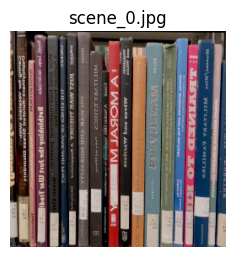

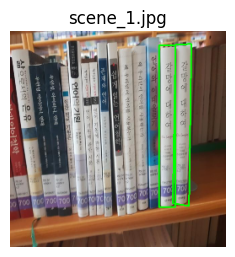

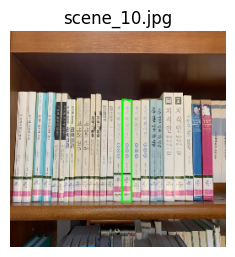

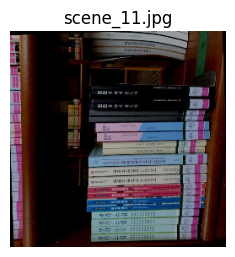

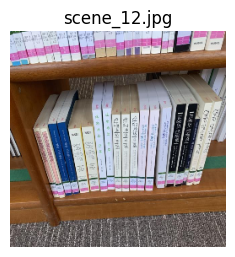

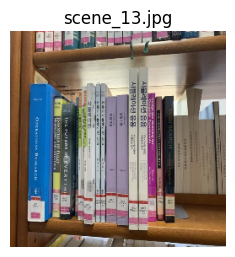

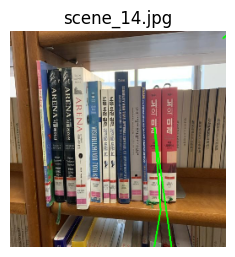

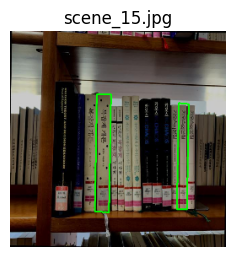

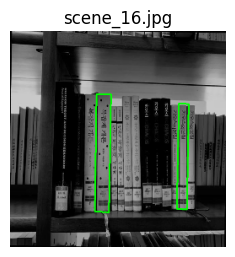

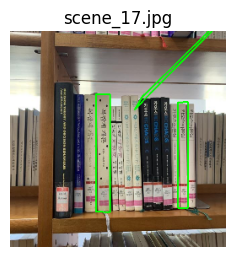

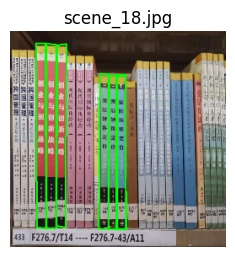

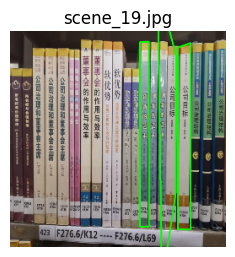

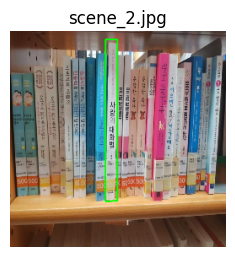

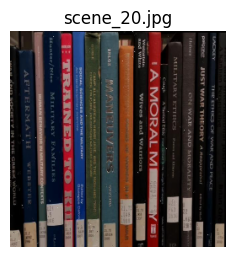

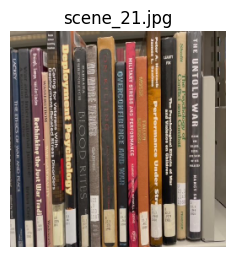

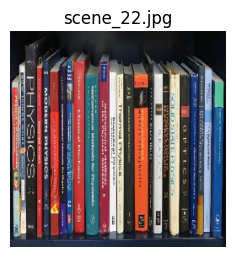

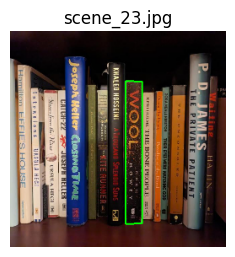

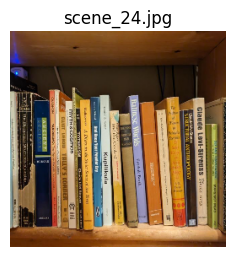

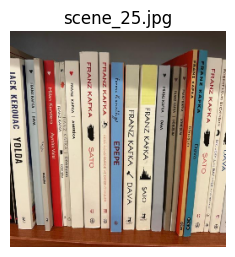

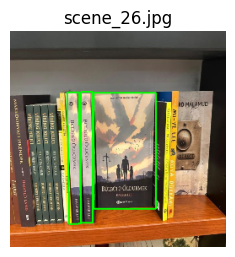

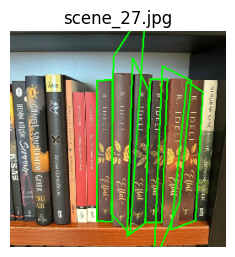

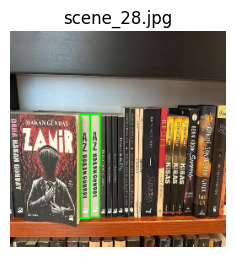

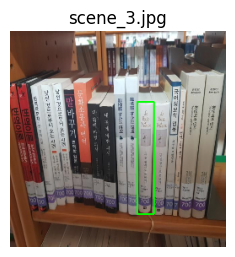

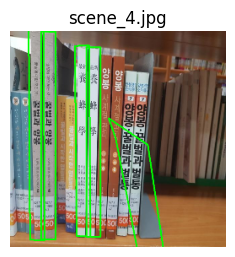

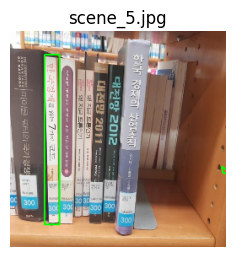

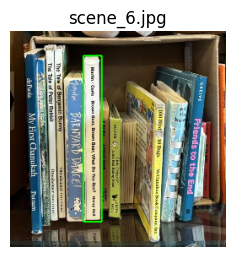

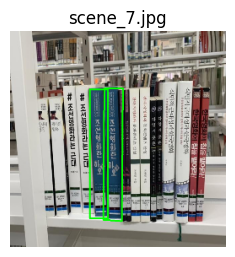

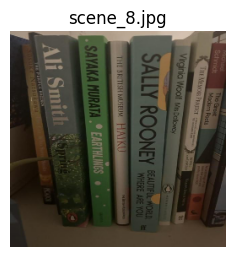

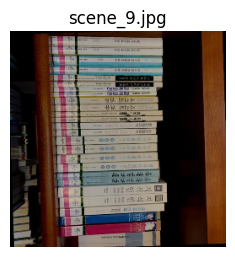

In [47]:
scenes = sorted(Path('dataset/scenes').glob('*'))
results = defaultdict(list)                # {scene_path: [ per-book reports ]}
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

for scene_path in scenes:
    scene_color = cv2.imread(str(scene_path), cv2.IMREAD_COLOR)
    scene_gray  = cv2.cvtColor(scene_color, cv2.COLOR_BGR2GRAY)
    sc_kp, sc_des_full = SIFT.detectAndCompute(scene_gray, None)

    overlay = scene_color.copy()           # will accumulate BBs
    scene_report = []                      # per book

    for title, ref in REFS.items():
        tmp_des = sc_des_full.copy()       # we’ll mask as we go
        tmp_kp  = list(sc_kp)
        copies  = []

        for _ in range(MAX_COPIES_PER_BOOK):
            good = match_once(ref, tmp_des, bf)
            if len(good) < MIN_MATCHES:
                break

            H, inliers = compute_homography(ref['kp'], tmp_kp, good)
            if H is None: break

            # project reference corners into scene
            corners_sc = cv2.perspectiveTransform(ref['corners'], H).reshape(-1,2)
            area = cv2.contourArea(corners_sc.astype(np.float32))

            # sanity-check area and rectangle shape
            if area < 200:  # very tiny or degenerate
                break

            cv2.polylines(overlay, [corners_sc.astype(np.int32)], True, (0,255,0), 3)
            copies.append(dict(corners=corners_sc, area=area))

            # mask this copy so we can detect others
            scene_gray = mask_polygon(scene_gray, corners_sc)
            tmp_kp, tmp_des = SIFT.detectAndCompute(scene_gray, None)

        # ---------- format output ----------
        if copies:
            scene_report.append((title, copies))

    results[scene_path.name] = scene_report

    # quick visual check
    plt.figure(figsize=(10*DRAW_SCALE,7*DRAW_SCALE))
    plt.imshow(cv2.cvtColor(cv2.resize(overlay,None, fx=DRAW_SCALE, fy=DRAW_SCALE), 
                            cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(scene_path.name)
    plt.show()


In [48]:
def bb_to_dict(bb):
    corners = np.rint(bb).astype(int).tolist()       # [[x,y], …]
    names   = ["top_left", "top_right", "bottom_right", "bottom_left"]
    area    = int(round(cv2.contourArea(bb.astype(np.float32))))
    return ", ".join(f"{n}: {tuple(c)}" for n, c in zip(names, corners)) + f", area: {area} px"


for scene, rep in results.items():
    print(f'\n=== {scene} ===')
    for title, copies in rep:
        print(f'{title} – {len(copies)} instance(s) found:')
        for i, c in enumerate(copies,1):
            print(f'  Instance {i} {{{bb_to_dict(c["corners"])}}}')



=== scene_0.jpg ===

=== scene_1.jpg ===
model_18 – 2 instance(s) found:
  Instance 1 {top_left: (442, 42), top_right: (491, 42), bottom_right: (491, 521), bottom_left: (442, 521), area: 23570 px}
  Instance 2 {top_left: (490, 41), top_right: (538, 39), bottom_right: (530, 519), bottom_left: (482, 510), area: 22802 px}

=== scene_10.jpg ===
model_19 – 1 instance(s) found:
  Instance 1 {top_left: (332, 204), top_right: (360, 204), bottom_right: (360, 504), bottom_left: (332, 505), area: 8434 px}

=== scene_11.jpg ===

=== scene_12.jpg ===

=== scene_13.jpg ===

=== scene_14.jpg ===
model_11 – 5 instance(s) found:
  Instance 1 {top_left: (347, 1113), top_right: (547, 1121), bottom_right: (429, 286), bottom_left: (446, 530), area: 65635 px}
  Instance 2 {top_left: (632, 22), top_right: (1358, -584), bottom_right: (730, -63), bottom_left: (813, -128), area: 910 px}
  Instance 3 {top_left: (632, 22), top_right: (1358, -584), bottom_right: (730, -63), bottom_left: (813, -128), area: 910 px}